# TOTVS Labs Data Challenge: customer churn analysis

Import the required modules

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import scipy
import pickle

import matplotlib.pyplot as plt
%matplotlib inline

import sys

# Churn Analysis

Even though the dataset has a *is_churn* label, it calls my attention that the classification remains as constant during the whole time. Therefore, I will create my own churn classification and, if I have time, I'll compare it with the given label.

We first define what churn is. To do that, as we don't know anything about the business, we will try to set the period of time determining when a customer is to be classified as 'churn'. We are tying to determine N so that if the customer doesn't start an order in N days, then we say that it's a case of churn.

In [2]:
with open("../models/customer_frequencies.pkl", "rb") as fd:
    customer_frequencies = pickle.load(fd)

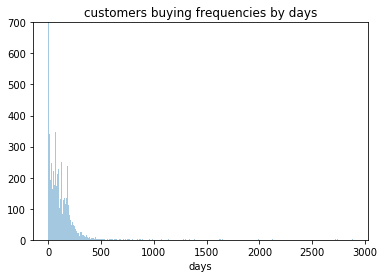

In [3]:
plt.title('customers buying frequencies by days')
plt.xlabel("days")
plt.ylim([0,700])
sns.distplot(customer_frequencies, bins = int(len(customer_frequencies)/20), kde=False)

We'll plot the same graph but limiting x/y axes

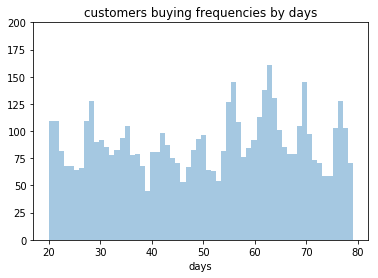

In [4]:
plt.title('customers buying frequencies by days')
plt.xlabel("days")
plt.ylim([0,200])
sns.distplot(list(filter(lambda x: x >= 20 and x < 80, customer_frequencies)), bins = 60, kde=False)

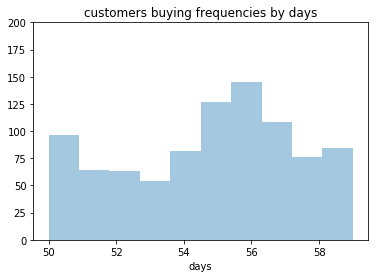

In [5]:
plt.title('customers buying frequencies by days')
plt.xlabel("days")
plt.ylim([0,200])
sns.distplot(list(filter(lambda x: x >= 50 and x < 60, customer_frequencies)), bins = 10, kde=False)

We will set N to be 53. This is just a subjective number, just based on the fact that there seems to be a "valley" around that number

Now, we have to manipulate the dataset so that we create the train/test sets. In the meantime, we create the features that we are going to be using afterwards...

In [6]:
original_df = pd.read_pickle("../models/df_preprocessed.pkl")

In [7]:
df = original_df.copy()

In [8]:
group = df.groupby(["customer_code", "register_date"])

In [9]:
df.columns

Index(['customer_code', 'group_code', 'is_churn', 'item_code',
       'item_total_price', 'order_id', 'quantity', 'register_date',
       'sales_channel', 'segment_code', 'seller_code', 'total_price',
       'unit_price'],
      dtype='object')

In [10]:
def get_daily_features(x):
    d = []
    d.append(x["group_code"].median())
    d.append(x["item_total_price"].mean())
    d.append(x["item_total_price"].std())
    d.append(x["quantity"].mean())
    d.append(x["quantity"].std())
    d.append(x["sales_channel"].median())
    d.append(x["segment_code"].median())
    d.append(x["total_price"].sum())
    return pd.Series(d, index=["group_code", "item_total_price_mean", "item_total_price_std",
                               "quantity_mean", "quantity_std", "sales_channel", 
                               "segment_code", "total_price"])

daily_features_df = group.apply(get_daily_features)

In [11]:
daily_features_df["number_of_daily_items"] = df.reset_index().groupby(["customer_code", "register_date"]).size()

In [12]:
daily_features_df.head()

group_code  item_total_price_mean  \
customer_code register_date                                      
0             2008-09-23            0.0             324.694444   
              2009-05-06            0.0             271.269091   
              2009-08-05            0.0               3.000000   
              2010-04-30            0.0              35.000000   
              2010-08-24            0.0             387.630000   

                             item_total_price_std  quantity_mean  \
customer_code register_date                                        
0             2008-09-23               228.952532      10.333333   
              2009-05-06               173.372300      10.636364   
              2009-08-05                      NaN       1.000000   
              2010-04-30                      NaN       1.000000   
              2010-08-24               229.082947       7.733333   

                             quantity_std  sales_channel  segment_code  \
customer_code register_date                                              
0             2008-09-23         4.862824            8.0           0.0   
              2009-05-06         5.590576            8.0           0.0   
              2009-08-05              NaN            2.0           0.0   
              2010-04-30              NaN            2.0           0.0   
              2010-08-24         5.812138            1.0           0.0   

                             total_price  number_of_daily_items  
customer_code register_date                                      
0             2008-09-23        84989.16                     18  
              2009-05-06        26726.37                     11  
              2009-08-05            3.00                      1  
              2010-04-30           35.00                      1  
              2010-08-24        73910.70                     15

The last day of data is July 8th, 2018. If we subtract 53:

In [13]:
import datetime

In [14]:
daily_features_df.reset_index().set_index("register_date").sort_index().tail(1).index[0] - datetime.timedelta(days=53)

datetime.date(2018, 5, 16)

We will take 70% as training set and 30% as test set, and we will use all the purchases from 2008-01-04 to 2018-05-15 to see the customer shopping "habits" and from 2018-05-16 to 2018-07-08 to determine tag the custermers as "churn" or "not churn"

In [15]:
last_date = datetime.date(2018,5,15)

In [16]:
training_period = daily_features_df.reset_index().set_index("register_date").sort_index()[:datetime.date(2018,5,15)]
testing_period = daily_features_df.reset_index().set_index("register_date").sort_index()[datetime.date(2018,5,16):]
len(set(testing_period.customer_code)), df.customer_code.max()

(313, 837)

There will be 313 churn customers out of 837...

In [17]:
churn_customers = set(testing_period.customer_code)

In [18]:
def get_customer_features(x):
    d = []
    d.append(x["group_code"].median())
    d.append(x["item_total_price_mean"].mean())
    d.append(x["quantity_mean"].mean())
    d.append(x["sales_channel"].median())
    d.append(x["segment_code"].median())
    d.append(x["total_price"].sum())
    d.append(x["total_price"].mean())
    d.append(x["number_of_daily_items"].mean())
    d.append(x["number_of_daily_items"].std())
    return pd.Series(d, index=["group_code", "item_total_price_mean", "quantity_mean", 
                               "sales_channel", "segment_code", "total_price", 
                               "total_price_mean", "number_of_daily_items_mean",
                               "number_of_daily_items_std"])

features_df = daily_features_df.reset_index().groupby("customer_code").apply(get_customer_features)

Adding features relative to the frequency on orders

In [19]:
register_date = training_period.reset_index().set_index("customer_code").register_date

In [20]:
def get_shift(x):
    d = []
    d.append((x["register_date"] - x["register_date"].shift(1)).mean())
    d.append((x["register_date"] - x["register_date"].shift(1)).std())
    return pd.Series(d, index=["purchase_freq_mean", "purchase_freq_std"])

purchase_freq = training_period.reset_index().groupby("customer_code").apply(get_shift)
purchase_freq["purchase_freq_mean"] = purchase_freq["purchase_freq_mean"].apply(lambda x: x.days)
purchase_freq["purchase_freq_std"] = purchase_freq["purchase_freq_std"].apply(lambda x: x.days)
purchase_freq["last_purchase"] = (datetime.date(2018,5,15) - \
                                  training_period.reset_index().sort_values(['customer_code','register_date']).groupby('customer_code').register_date.last())
purchase_freq["last_purchase"] = purchase_freq["last_purchase"].apply(lambda x: x.days)

In [21]:
features_df["purchase_freq_mean"] = purchase_freq["purchase_freq_mean"]
features_df["purchase_freq_std"] = purchase_freq["purchase_freq_std"]
features_df["last_purchase"] = purchase_freq["last_purchase"]

In [22]:
features_df.loc[features_df["purchase_freq_mean"].isna(), 'purchase_freq_mean'] = 1
features_df.loc[features_df["purchase_freq_std"].isna(), 'purchase_freq_std'] = 0

Adding the churn label

In [23]:
features_df["my_churn"] = features_df.reset_index().customer_code.apply(lambda x: x in churn_customers)

In [24]:
features_df.head()

,group_code,item_total_price_mean,quantity_mean,sales_channel,segment_code,total_price,total_price_mean,number_of_daily_items_mean,number_of_daily_items_std,purchase_freq_mean,purchase_freq_std,last_purchase,my_churn
customer_code,,,,,,,,,,,,,
0,0.0,520.651730,8.981093,0.0,0.0,785677.26,41351.434737,9.421053,4.879843,200.0,147.0,111,True
1,0.0,199.841094,7.057709,0.0,0.0,1083620.64,25800.491429,11.214286,4.936355,89.0,35.0,64,False
2,0.0,314.731072,10.510510,1.0,0.0,841537.44,21577.883077,7.871795,2.307647,99.0,37.0,83,True
3,0.0,784.640276,20.010695,1.0,0.0,5102786.19,82303.003065,10.241935,7.919028,61.0,47.0,7,False
4,0.0,421.877465,15.313200,1.0,0.0,1076850.86,30767.167429,8.600000,5.292614,106.0,78.0,117,False


# Churn Modelling

We already have the features, let's try to model the "churn"

In [25]:
features_df.head()

,group_code,item_total_price_mean,quantity_mean,sales_channel,segment_code,total_price,total_price_mean,number_of_daily_items_mean,number_of_daily_items_std,purchase_freq_mean,purchase_freq_std,last_purchase,my_churn
customer_code,,,,,,,,,,,,,
0,0.0,520.651730,8.981093,0.0,0.0,785677.26,41351.434737,9.421053,4.879843,200.0,147.0,111,True
1,0.0,199.841094,7.057709,0.0,0.0,1083620.64,25800.491429,11.214286,4.936355,89.0,35.0,64,False
2,0.0,314.731072,10.510510,1.0,0.0,841537.44,21577.883077,7.871795,2.307647,99.0,37.0,83,True
3,0.0,784.640276,20.010695,1.0,0.0,5102786.19,82303.003065,10.241935,7.919028,61.0,47.0,7,False
4,0.0,421.877465,15.313200,1.0,0.0,1076850.86,30767.167429,8.600000,5.292614,106.0,78.0,117,False


In [26]:
X = features_df.reset_index().drop(columns=["my_churn", "customer_code"])
y = features_df.my_churn

In [27]:
columns_to_normalize = ["item_total_price_mean",
                        "quantity_mean",
                        "total_price",
                        "total_price_mean",
                        "number_of_daily_items_mean",
                        "number_of_daily_items_std"]

Normalizing the data...

In [28]:
for column in columns_to_normalize:
    X[column] = (X[column] - X[column].mean()) / X[column].std()

In [29]:
X.head()

,group_code,item_total_price_mean,quantity_mean,sales_channel,segment_code,total_price,total_price_mean,number_of_daily_items_mean,number_of_daily_items_std,purchase_freq_mean,purchase_freq_std,last_purchase
0,0.0,0.817597,-0.218193,0.0,0.0,-0.028960,0.147919,-0.058543,-0.098107,200.0,147.0,111
1,0.0,-0.445183,-0.396837,0.0,0.0,-0.012248,-0.088858,0.374417,-0.081431,89.0,35.0,64
2,0.0,0.007049,-0.076141,1.0,0.0,-0.025827,-0.153151,-0.432596,-0.857165,99.0,37.0,83
3,0.0,1.856713,0.806236,1.0,0.0,0.213199,0.771444,0.139652,0.798759,61.0,47.0,7
4,0.0,0.428800,0.369933,1.0,0.0,-0.012627,-0.013236,-0.256778,0.023702,106.0,78.0,117


getting rid of NAs

In [30]:
X.loc[X.number_of_daily_items_std.isna(), "number_of_daily_items_std"] = 0

The data is ready to model and evaluate it... We will try with a Random Forest

In [31]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

In [32]:
clf = RandomForestClassifier(n_estimators=200)
rf_dist={"max_depth": [3,5,10,None],
         "max_features": randint(1,len(X.columns)),
         "criterion": ["gini","entropy"],
         "bootstrap": [True,False],
         "min_samples_leaf": randint(1,10)
        }
searcher = RandomizedSearchCV(clf, param_distributions=rf_dist,
                              n_jobs=-1, n_iter=100, cv=10)
searcher.fit(X,y)
params = searcher.best_params_
score = searcher.best_score_
params["n_estimators"]=200
print("best params", params)
print("score", score)

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


best params {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 5, 'max_features': 4, 'min_samples_leaf': 1, 'n_estimators': 200}
score 0.7171837708830548


We can see what the most important features are...

In [33]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

In [34]:
X_train, X_test, y_train, y_test = \
    train_test_split(X.index, y, test_size=0.3)
X_train = X.iloc[X_train]
X_test = X.iloc[X_test]
model = DecisionTreeClassifier()
model.fit(X_train, y_train)
predicted = model.predict(X_test)
matrix = confusion_matrix(y_test, predicted)
print(matrix)

[[104  55]
 [ 34  59]]


In [35]:
for name, importance in zip(X.columns, model.feature_importances_):
    print(name, importance)

group_code 0.0
item_total_price_mean 0.06096604670692063
quantity_mean 0.04482130182657554
sales_channel 0.003200195950464259
segment_code 0.036175722332468185
total_price 0.09416678086324401
total_price_mean 0.0862521715345891
number_of_daily_items_mean 0.07620034486854567
number_of_daily_items_std 0.08000536742764873
purchase_freq_mean 0.08091379606149832
purchase_freq_std 0.1534565294359787
last_purchase 0.2838417429920667


The last purchase date seems to be very important... let's add the last 3 purchases

In [36]:
tails = training_period.reset_index().sort_values(['customer_code','register_date']).groupby('customer_code').tail(3)
tails = tails.set_index("customer_code").register_date
third_last = tails.groupby("customer_code").head(1)
second_last = tails.groupby("customer_code").head(2).groupby("customer_code").tail(1)

In [37]:
features_df["second_last"] = (datetime.date(2018,5,15) - second_last).apply(lambda x: x.days)
features_df["third_last"] = (datetime.date(2018,5,15) - third_last).apply(lambda x: x.days)

In [38]:
X = features_df.reset_index().drop(columns=["my_churn", "customer_code"])
y = features_df.my_churn

Normalize them again:

In [39]:
for column in columns_to_normalize + ["second_last", "third_last"]:
    X[column] = (X[column] - X[column].mean()) / X[column].std()

In [40]:
X.loc[X.number_of_daily_items_std.isna(), "number_of_daily_items_std"] = 0

In [41]:
clf = RandomForestClassifier(n_estimators=200)
rf_dist={"max_depth": [3,5,10,None],
         "max_features": randint(1,len(X.columns)),
         "criterion": ["gini","entropy"],
         "bootstrap": [True,False],
         "min_samples_leaf": randint(1,10)
        }
searcher = RandomizedSearchCV(clf, param_distributions=rf_dist,
                              n_jobs=-1, n_iter=100, cv=10)
searcher.fit(X,y)
params = searcher.best_params_
score = searcher.best_score_
params["n_estimators"]=200
print("best params", params)
print("score", score)

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


best params {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 10, 'max_features': 5, 'min_samples_leaf': 2, 'n_estimators': 200}
score 0.7422434367541766


In [42]:
# Cross Validation Classification Accuracy
random_state = 42
kfold = KFold(n_splits=10, random_state=random_state)
model = RandomForestClassifier(**params)
scoring = 'accuracy'
results = cross_val_score(model, X, y, cv=kfold, scoring=scoring)
print("Accuracy: %f (%f)" % (results.mean(), results.std()))

Accuracy: 0.734022 (0.058892)


### Summary

* we performed churn analysis 
* we implemented a RF to predict if a customer is going to be a churn or not
* we improved the model by adding more relevant features
* the results are not good. About 63% of customers are not going to churn and we tagged them with a 73% of accuracy

### What's next (TODO)

The following is a list of things that could have been done (but I didn't because of lack of time. I wanted to work 5 hours; anyway I guess I did work longer than that)
* the model should be updated online or on a period of time (like daily basis)
* we should try with other models. I used decision trees because they let you easily rank the features
* we have just evaluated the model using the accuracy. We should try with some other measures, including at least precision and recall.

# DRAFT

In [52]:
comparison = pd.DataFrame(data=np.array([X_test.last_purchase.values, predicted]).T, columns=["last_purchase", "prediction"])

In [53]:
len(comparison[(comparison.last_purchase == 0) & (comparison.prediction == 0)])

5

In [54]:
len(comparison[(comparison.last_purchase == 0) & (comparison.prediction == 1)])

2

In [55]:
len(comparison[(comparison.last_purchase > 0) & (comparison.prediction == 0)])

133

In [56]:
len(comparison[(comparison.last_purchase > 0) & (comparison.prediction == 1)])

112

In [57]:
1 - y_test.sum()/len(y_test)

0.6309523809523809

In [58]:
from sklearn.svm import SVC

In [60]:
# Cross Validation Classification Accuracy
random_state = 42
kfold = KFold(n_splits=10, random_state=random_state)
clf = SVC(kernel='rbf')  
# svclassifier.fit(X_train, y_train)  
scoring = 'accuracy'
results = cross_val_score(clf, X, y, cv=kfold, scoring=scoring)
print("Accuracy: %f (%f)" % (results.mean(), results.std()))

/opt/conda/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default 

Accuracy: 0.630164 (0.053710)


/opt/conda/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
